In [2]:
from mylib.statistic_test import *

code_id = '0345 - Convergent Dynamics Experiments'
loc = os.path.join(figpath, code_id)
mkdir(loc)

from mylib.model import ContinuousHiddenStateModel
from mylib.model import ProbabilityRNN

from mylib.field.tracker_v2 import Tracker2d

file_loc = join(figpath, "0337 - Model Losses")

if exists(join(figdata, code_id+'.pkl')):
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
else:
    Data = {
        "Step": [],
        "P": [],
        "MiceID": [],
        "Paradigm": [],
    }
    
    for i in tqdm(range(len(f_CellReg_modi))):
        if f_CellReg_modi['Type'][i] != 'Real' or f_CellReg_modi['maze_type'][i] == 0:
            continue
        
        with open(f_CellReg_modi['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)  
              
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            paradigm = 'MA' if f_CellReg_modi['maze_type'][i] == 1 else 'MB'
        
            with open(join(file_loc, f'{int(f_CellReg_modi["MiceID"][i])}_{paradigm}.pkl'), 'rb') as handle:
                res = pickle.load(handle)
            
            M53: ContinuousHiddenStateModel = res[-5]
            tracker = Tracker2d(field_reg=trace['field_reg'])
            sequences = tracker.convert_to_sequence()
            predicted_prob = M53.get_predicted_prob(sequences)
            
            for j in range(len(predicted_prob)):
                Data['Step'].append(np.arange(len(predicted_prob[j])))
                Data['P'].append(predicted_prob[j])
                Data['MiceID'].append(np.repeat(int(f_CellReg_modi['MiceID'][i]), len(predicted_prob[j])))
                Data['Paradigm'].append(np.repeat(paradigm, len(predicted_prob[j])))
            
        else:
            info = {"ReverseMaze": ["MAf", "MAb"], "HairpinMaze": ["HPf", "HPb"]}
            directions = ['cis', 'trs']
            for n, paradigm in enumerate(info[f_CellReg_modi['paradigm'][i]]):
                with open(join(file_loc, f'{int(f_CellReg_modi["MiceID"][i])}_{paradigm}.pkl'), 'rb') as handle:
                    res = pickle.load(handle)
                
                M53: ContinuousHiddenStateModel = res[-5]
                tracker = Tracker2d(field_reg=trace[directions[n]]['field_reg'])
                sequences = tracker.convert_to_sequence()
                predicted_prob = M53.get_predicted_prob(sequences)
                
                for j in range(len(predicted_prob)):
                    Data['Step'].append(np.arange(len(predicted_prob[j])))
                    Data['P'].append(predicted_prob[j])
                    Data['MiceID'].append(np.repeat(int(f_CellReg_modi['MiceID'][i]), len(predicted_prob[j])))
                    Data['Paradigm'].append(np.repeat(paradigm, len(predicted_prob[j])))
                    
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+'.xlsx'), index=False)

        E:\Data\FinalResults\0345 - Convergent Dynamics Experiments is already existed!
Using device: cuda
Using device: cuda


<Axes: xlabel='P', ylabel='PMF'>

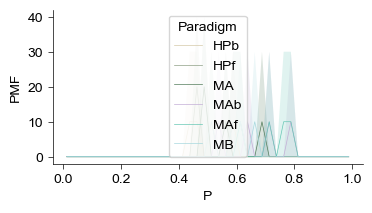

In [16]:
if exists(join(figdata, code_id+' [Histogram].pkl')):
    with open(join(figdata, code_id+' [Histogram].pkl'), 'rb') as handle:
        HData = pickle.load(handle)
else:
    HData = {
        "Step": [],
        "P": [],
        "MiceID": [],
        "Paradigm": [],
        "PMF": [],
    }
    
    paradigms = np.unique(Data['Paradigm'])
    
    for paradigm in paradigms:
        for m in np.unique(Data['MiceID']):
            idx = np.where((Data['Paradigm'] == paradigm) & (Data['MiceID'] == m))[0]
            n_steps = int(np.max(Data['Step'][idx]) + 1)
            
            mat = np.zeros((n_steps, 40)) * np.nan
            for i in range(n_steps):
                indices = np.where(Data['Step'][idx] == i)[0]
                mat[i, :] = np.histogram(
                    Data['P'][idx][indices],
                    bins=40,
                    range=(0, 1),
                    density=True
                )[0]
            
                HData['Step'].append(np.repeat(i, 40))
                HData['P'].append(np.linspace(0.0125, 0.9875, 40))
                HData['MiceID'].append(np.repeat(m, 40))
                HData['Paradigm'].append(np.repeat(paradigm, 40))
                HData['PMF'].append(mat[i, :])
                
    for k in HData.keys():
        HData[k] = np.concatenate(HData[k])
        
    with open(join(figdata, code_id+' [Histogram].pkl'), 'wb') as handle:
        pickle.dump(HData, handle)
    
    D = pd.DataFrame(HData)
    D.to_excel(join(figdata, code_id+' [Histogram].xlsx'), index=False)
    
idx = np.where(HData['Step'] == 0)[0]
SubData = SubDict(HData, HData.keys(), idx)
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="P",
    y="PMF",
    hue="Paradigm",
    data=SubData,
    palette=['#D4C9A8', '#8E9F85', '#527C5A', '#C3AED6', '#66C7B4', '#A7D8DE'],
    ax=ax,
    linewidth=0.5,
    err_kws={"edgecolor": None}
)
plt.savefig()


In [2]:
from mylib.statistic_test import *
from mylib.field.counter import calculate_superstable_fraction
from mylib.field.tracker_v2 import Tracker2d

code_id = '0345 - Convergent Dynamics Experiments'
loc = os.path.join(figpath, code_id)
mkdir(loc)
from mylib.model import ContinuousHiddenStateModel
from mylib.model import ProbabilityRNN

from mylib.field.tracker_v2 import Tracker2d

file_loc = join(figpath, "0337 - Model Losses")
def calc_superstable(field_reg, thres=np.arange(2, 14)):
    
    superstable_frac = np.zeros((thres.shape[0], field_reg.shape[0]))
    
    for i in tqdm(range(1, field_reg.shape[0])):
        for dt in np.arange(i):
            active_idx = np.where((field_reg[i, :] == 1))[0]
            superstable_idx = np.where(np.sum(field_reg[dt:i+1, :], axis=0) == i-dt+1)[0]
            superstable_frac[i-dt+1-thres[0], i] = superstable_idx.shape[0] / active_idx.shape[0]
    
    return superstable_frac

if exists(join(figdata, code_id+'  [Superstable].pkl')):
    with open(join(figdata, code_id+' [Superstable].pkl'), 'rb') as handle:
        SData = pickle.load(handle)
        
    for k in SData.keys():
        print(SData[k].shape)
else:
    SData = {
        "Session": [],
        "Step": [],
        "Superstable": [],
        "MiceID": [],
        "Paradigm": [],
        "Type": []
    }
    
    for k in tqdm(range(len(f_CellReg_modi))):
        if f_CellReg_modi['Type'][k] != 'Real' or f_CellReg_modi['maze_type'][k] == 0:
            continue
        
        with open(f_CellReg_modi['Trace File'][k], 'rb') as handle:
            trace = pickle.load(handle)  
              
        if f_CellReg_modi['paradigm'][k] == 'CrossMaze':
            paradigm = 'MA' if f_CellReg_modi['maze_type'][k] == 1 else 'MB'
        
            with open(join(file_loc, f'{int(f_CellReg_modi["MiceID"][k])}_{paradigm}.pkl'), 'rb') as handle:
                res = pickle.load(handle)
            
            M53: ContinuousHiddenStateModel = res[-5]
            tracker = Tracker2d(field_reg=trace['field_reg'])
            sequences = tracker.convert_to_sequence()
            simu_reg, _ = M53.simulate_across_day(13, n_fields=2000)
            simu_reg[np.isnan(simu_reg)] = 0
            
            super_stable = calc_superstable(simu_reg.T, np.arange(2, 14))
            
            for i in range(super_stable.shape[0]):
                SData["Session"].append(np.arange(super_stable.shape[1]))
                SData["Step"].append(np.repeat(i+2, super_stable.shape[1]))
                SData["Superstable"].append(super_stable[i, :])
                SData["MiceID"].append(np.repeat(int(f_CellReg_modi['MiceID'][k]), super_stable.shape[1]))
                SData["Paradigm"].append(np.repeat(paradigm, super_stable.shape[1]))
                SData["Type"].append(np.repeat("Simu", super_stable.shape[1]))
            
            field_reg = Tracker2d.reconstruct_reg(trace['field_reg'], thre=10)

            try:
                super_stable = calc_superstable(field_reg[:13], np.arange(2, 14))
            except:
                super_stable = calc_superstable(field_reg[:12], np.arange(2, 13))
                
            for i in range(super_stable.shape[0]):
                SData["Session"].append(np.arange(super_stable.shape[1]))
                SData["Step"].append(np.repeat(i+2, super_stable.shape[1]))
                SData["Superstable"].append(super_stable[i, :])
                SData["MiceID"].append(np.repeat(int(f_CellReg_modi['MiceID'][k]), super_stable.shape[1]))
                SData["Paradigm"].append(np.repeat(paradigm, super_stable.shape[1]))
                SData["Type"].append(np.repeat("Real", super_stable.shape[1])) 
                           
        else:
            info = {"ReverseMaze": ["MAf", "MAb"], "HairpinMaze": ["HPf", "HPb"]}
            directions = ['cis', 'trs']
            for n, paradigm in enumerate(info[f_CellReg_modi['paradigm'][k]]):
                with open(join(file_loc, f'{int(f_CellReg_modi["MiceID"][k])}_{paradigm}.pkl'), 'rb') as handle:
                    res = pickle.load(handle)
                
                M53: ContinuousHiddenStateModel = res[-5]
                tracker = Tracker2d(field_reg=trace[directions[n]]['field_reg'])
                sequences = tracker.convert_to_sequence()
                simu_reg, _ = M53.simulate_across_day(13, n_fields=2000)
                
                super_stable = calc_superstable(simu_reg.T, np.arange(2, 14))
                
                for i in range(super_stable.shape[0]):
                    SData["Session"].append(np.arange(super_stable.shape[1]))
                    SData["Step"].append(np.repeat(i+2, super_stable.shape[1]))
                    SData["Superstable"].append(super_stable[i, :])
                    SData["MiceID"].append(np.repeat(int(f_CellReg_modi['MiceID'][k]), super_stable.shape[1]))
                    SData["Paradigm"].append(np.repeat(paradigm, super_stable.shape[1])) 
                    SData["Type"].append(np.repeat("Simu", super_stable.shape[1]))
                
                field_reg = Tracker2d.reconstruct_reg(trace[directions[n]]['field_reg'], thre=5)
                field_reg[np.isnan(field_reg)] = 0
                super_stable = calculate_superstable_fraction(field_reg, np.arange(2, 8))
                for i in range(super_stable.shape[0]):
                    SData["Session"].append(np.arange(super_stable.shape[1]))
                    SData["Step"].append(np.repeat(i+2, super_stable.shape[1]))
                    SData["Superstable"].append(super_stable[i, :])
                    SData["MiceID"].append(np.repeat(int(f_CellReg_modi['MiceID'][k]), super_stable.shape[1]))
                    SData["Paradigm"].append(np.repeat(paradigm, super_stable.shape[1])) 
                    SData["Type"].append(np.repeat("Real", super_stable.shape[1]))
                    
    for k in SData.keys():
        SData[k] = np.concatenate(SData[k])
        
    with open(join(figdata, code_id+' [Superstable].pkl'), 'wb') as handle:
        pickle.dump(SData, handle)
    
    SD = pd.DataFrame(SData)
    SD.to_excel(join(figdata, code_id+' [Superstable].xlsx'), index=False)

        E:\Data\FinalResults\0345 - Convergent Dynamics Experiments is already existed!


100%|██████████| 68/68 [00:59<00:00,  1.14it/s]


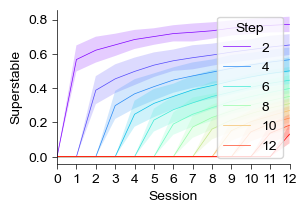

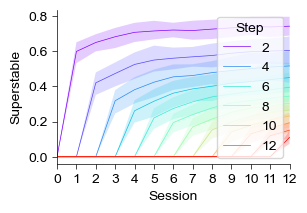

In [4]:
idx = np.where((SData['Paradigm'] == 'MA')&(SData['Type'] == 'Simu'))[0]
SubData = SubDict(SData, SData.keys(), idx)
fig = plt.figure(figsize=(3, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Session",
    y="Superstable",
    hue="Step",
    data=SubData,
    palette="rainbow",
    ax=ax,
    linewidth=0.5,
    err_kws={"edgecolor": None}
)
ax.set_xlim([0, 12])
ax.set_xticks(np.linspace(0, 12, 13))
plt.savefig(join(loc, "Superstable [MA].png"), dpi = 600)
plt.savefig(join(loc, "Superstable [MA].svg"), dpi = 600)
plt.show()

idx = np.where((SData['Paradigm'] == 'MB')&(SData['Type'] == 'Simu'))[0]
SubData = SubDict(SData, SData.keys(), idx)
fig = plt.figure(figsize=(3, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Session",
    y="Superstable",
    hue="Step",
    data=SubData,
    palette="rainbow",
    ax=ax,
    linewidth=0.5,
    err_kws={"edgecolor": None}
)
ax.set_xlim([0, 12])
ax.set_xticks(np.linspace(0, 12, 13))
plt.savefig(join(loc, "Superstable [MB].png"), dpi = 600)
plt.savefig(join(loc, "Superstable [MB].svg"), dpi = 600)

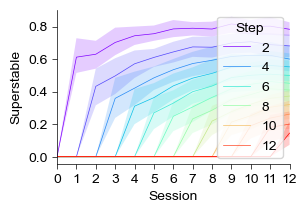

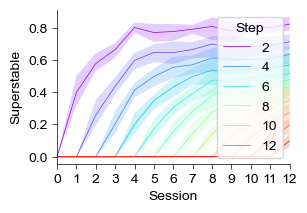

In [3]:
idx = np.where((SData['Paradigm'] == 'MA')&(SData['Type'] == 'Real'))[0]
SubData = SubDict(SData, SData.keys(), idx)
fig = plt.figure(figsize=(3, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Session",
    y="Superstable",
    hue="Step",
    data=SubData,
    palette="rainbow",
    ax=ax,
    linewidth=0.5,
    err_kws={"edgecolor": None}
)
ax.set_xlim([0, 12])
ax.set_xticks(np.linspace(0, 12, 13))
plt.savefig(join(loc, "Superstable [MA Real].png"), dpi = 600)
plt.savefig(join(loc, "Superstable [MA Real].svg"), dpi = 600)
plt.show()

idx = np.where((SData['Paradigm'] == 'MB')&(SData['Type'] == 'Real'))[0]
SubData = SubDict(SData, SData.keys(), idx)
fig = plt.figure(figsize=(3, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Session",
    y="Superstable",
    hue="Step",
    data=SubData,
    palette="rainbow",
    ax=ax,
    linewidth=0.5,
    err_kws={"edgecolor": None}
)
ax.set_xlim([0, 12])
ax.set_xticks(np.linspace(0, 12, 13))
plt.savefig(join(loc, "Superstable [MB Real].png"), dpi = 600)
plt.savefig(join(loc, "Superstable [MB Real].svg"), dpi = 600)